In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

[(64, 64), (64, 64), (64, 64), (64, 64), (64, 64), (64, 64), (64, 64), (64, 64), (64, 64), (64, 64)]
[[64 64]]


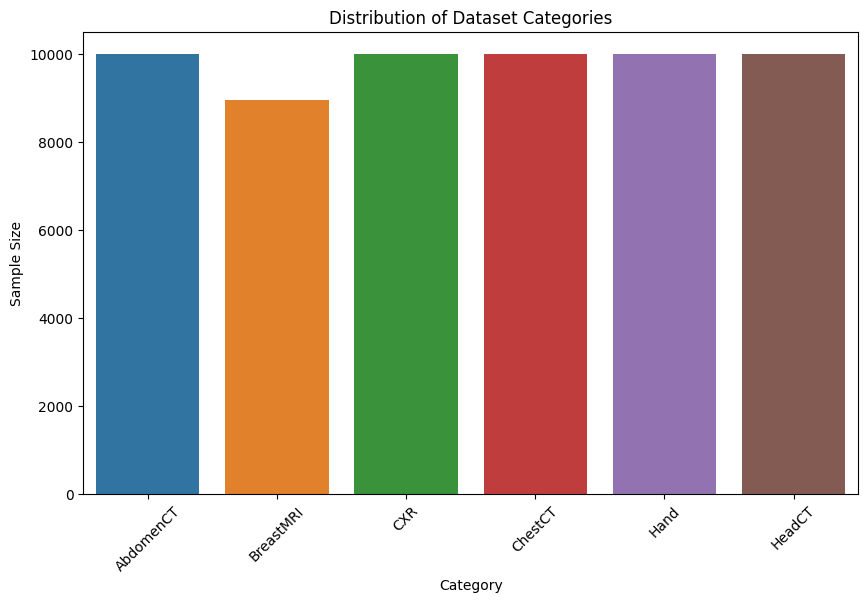

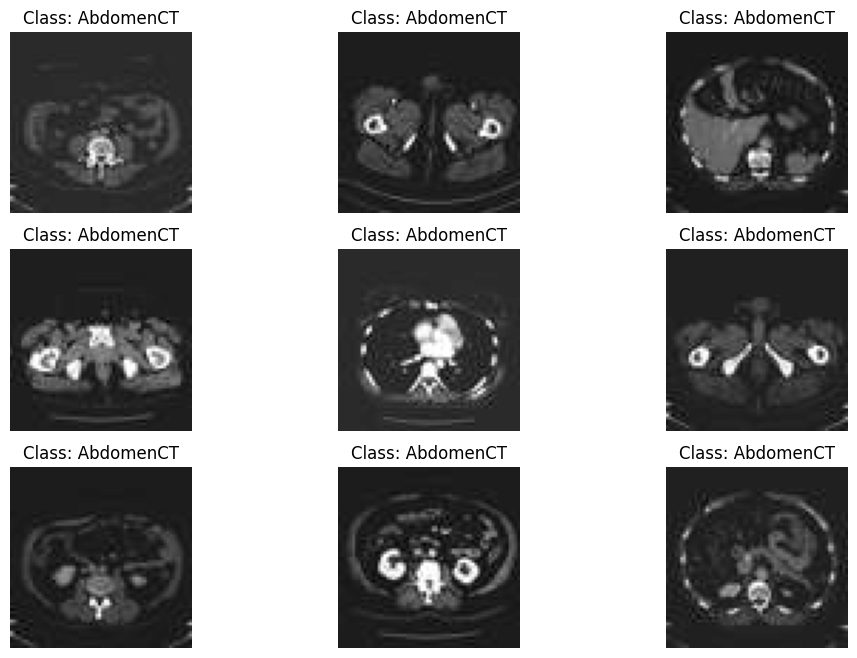

Shape of first 10 images in X_train: [(64, 64), (64, 64), (64, 64), (64, 64), (64, 64), (64, 64), (64, 64), (64, 64), (64, 64), (64, 64)]
Unique shapes in X_train: [[64 64]]
Shape of first 10 images in X_test: [(64, 64), (64, 64), (64, 64), (64, 64), (64, 64), (64, 64), (64, 64), (64, 64), (64, 64), (64, 64)]
Unique shapes in X_test: [[64 64]]


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


SVM Classifier results:
              precision    recall  f1-score   support

   AbdomenCT       0.78      0.94      0.85      2045
   BreastMRI       0.98      1.00      0.99      1751
         CXR       0.90      1.00      0.94      1963
     ChestCT       0.99      0.65      0.79      1989
        Hand       0.99      0.99      0.99      2023
      HeadCT       0.99      0.98      0.99      2020

    accuracy                           0.93     11791
   macro avg       0.94      0.93      0.93     11791
weighted avg       0.94      0.93      0.92     11791

SVM accuracy rate: 0.9274870664065813


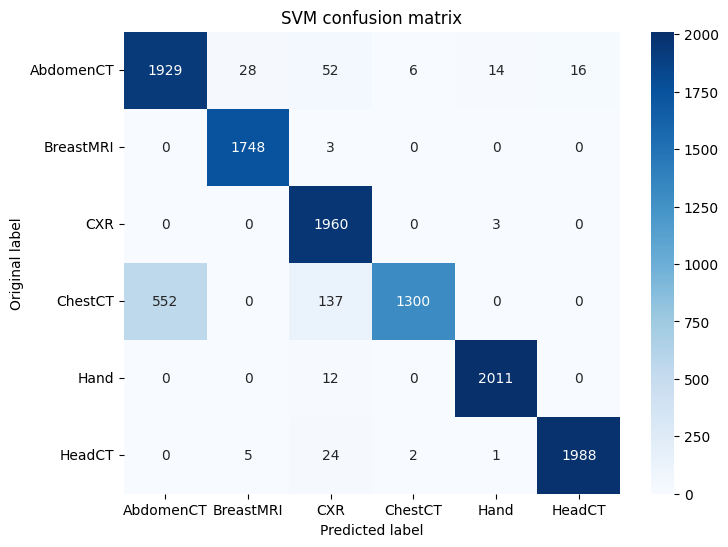

k-NN Classifier results:
              precision    recall  f1-score   support

   AbdomenCT       1.00      1.00      1.00      2045
   BreastMRI       1.00      1.00      1.00      1751
         CXR       0.99      1.00      0.99      1963
     ChestCT       1.00      1.00      1.00      1989
        Hand       1.00      0.99      0.99      2023
      HeadCT       1.00      1.00      1.00      2020

    accuracy                           1.00     11791
   macro avg       1.00      1.00      1.00     11791
weighted avg       1.00      1.00      1.00     11791

k-NN accuracy rate: 0.9961835298108727


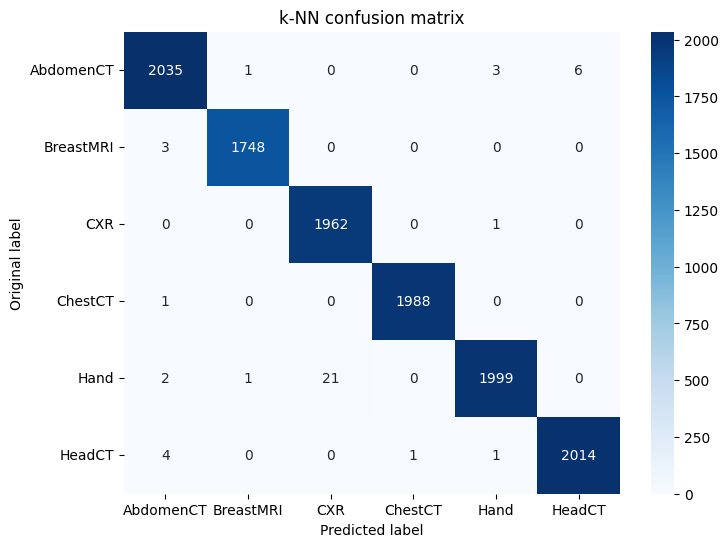

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


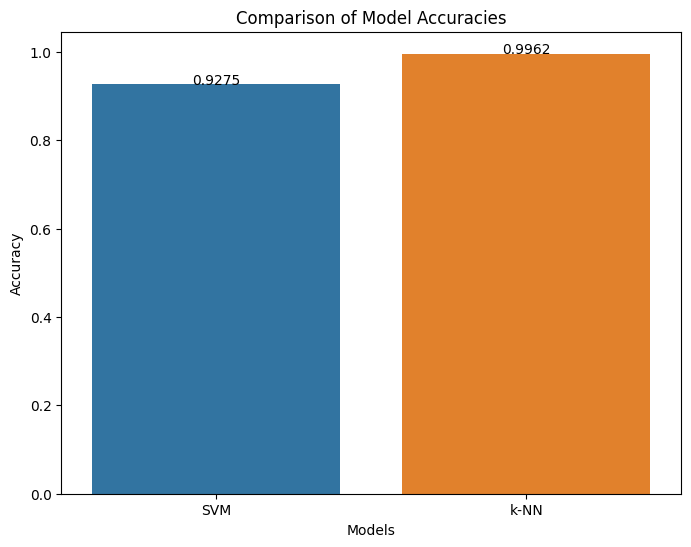

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from skimage.feature import hog
from skimage.filters import sobel
from skimage.morphology import binary_erosion, binary_dilation
from skimage.exposure import histogram

# Define the directory where the medical MNIST data resides on Kaggle
data_dir = '/kaggle/input/medical-mnist'
# Define the target size for resizing images
image_size = 64
# Define the names of the classes in our dataset
classes = ['AbdomenCT', 'BreastMRI', 'CXR', 'ChestCT', 'Hand', 'HeadCT']

# Function to load the image data and corresponding labels from the directory
def load_data(data_directory):
    images = []
    labels = []
    try:
        # Iterate through each class directory
        for class_id, class_name in enumerate(classes):
            class_path = os.path.join(data_directory, class_name)
            # Iterate through each image file in the class directory
            for img_filename in os.listdir(class_path):
                img_filepath = os.path.join(class_path, img_filename)
                # Read the image in grayscale format
                img = cv2.imread(img_filepath, cv2.IMREAD_GRAYSCALE)
                # Check if the image was loaded successfully
                if img is not None:
                    # Resize the image to the defined target size (commented out initially)
                    # img = cv2.resize(img, (image_size, image_size))
                    # Ensure the image data type is unsigned 8-bit integer
                    img = img.astype(np.uint8)
                    images.append(img)
                    labels.append(class_id)

        # Print the shapes of the first 10 loaded images for inspection
        print([img.shape for img in images[:10]])
        # Print the unique shapes of all loaded images to check for consistency
        print(np.unique([img.shape for img in images], axis=0))
        return np.array(images), np.array(labels)
    except FileNotFoundError:
        print(f"Error: Directory not found at {data_directory}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
    return np.array([]), np.array([])

# Function to extract Histogram of Oriented Gradients (HOG) features from a set of images
def extract_hog_features(image_set):
    hog_features = []
    for img in image_set:
        # Compute HOG features using predefined parameters
        fd = hog(img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=False)
        hog_features.append(fd)
    return np.array(hog_features)

# Function to extract edge features using the Sobel filter
def extract_edge_features(image_set):
    edge_features = []
    for img in image_set:
        # Apply the Sobel filter to detect edges
        edge_img = sobel(img)
        # Flatten the edge image into a 1D array
        edge_features.append(edge_img.flatten())
    return np.array(edge_features)

# Function to extract basic morphological features (erosion and dilation)
def extract_morphology_features(image_set):
    morph_features = []
    for img in image_set:
        # Convert the grayscale image to binary using a threshold
        binary_img = img > 127
        # Apply binary erosion
        eroded_img = binary_erosion(binary_img)
        # Apply binary dilation
        dilated_img = binary_dilation(binary_img)
        # Concatenate the flattened eroded and dilated images
        morph_feature = np.concatenate([eroded_img.flatten(), dilated_img.flatten()])
        morph_features.append(morph_feature)
    return np.array(morph_features)

# Function to extract histogram features from the images
def extract_histogram_features(image_set):
    hist_features = []
    num_bins = 256
    for img in image_set:
        # Calculate the histogram of the image
        hist, _ = histogram(img, nbins=num_bins, source_range='image')
        # Pad or truncate the histogram to ensure a consistent length
        if hist.shape[0] < num_bins:
            padding = np.zeros(num_bins - hist.shape[0])
            hist_padded = np.concatenate([hist, padding])
            hist_features.append(hist_padded)
        elif hist.shape[0] > num_bins:
            hist_truncated = hist[:num_bins]
            hist_features.append(hist_truncated)
        else:
            hist_features.append(hist)
    return np.array(hist_features)

# Function to extract all defined features and concatenate them
def extract_all_features(image_set):
    hog_features = extract_hog_features(image_set)
    edge_features = extract_edge_features(image_set)
    morph_features = extract_morphology_features(image_set)
    hist_features = extract_histogram_features(image_set)

    expected_hog_len = 1764
    expected_edge_len = image_size * image_size
    expected_morph_len = 2 * image_size * image_size
    expected_hist_len = 256

    if hog_features.shape[1] != expected_hog_len:
        print(f"Warning: HOG feature length is {hog_features.shape[1]}, expected {expected_hog_len}")
    if edge_features.shape[1] != expected_edge_len:
        print(f"Warning: Edge feature length is {edge_features.shape[1]}, expected {expected_edge_len}")
    if morph_features.shape[1] != expected_morph_len:
        print(f"Warning: Morphology feature length is {morph_features.shape[1]}, expected {expected_morph_len}")
    if hist_features.shape[1] != expected_hist_len:
        print(f"Warning: Histogram feature length is {hist_features.shape[1]}, expected {expected_hist_len}")

    return np.hstack([hog_features, edge_features, morph_features, hist_features])

# Function to train and evaluate a given classification model
def train_and_evaluate_model(model, X_train_data, y_train_labels, X_test_data, y_test_labels, model_name):
    # Train the model on the training data
    model.fit(X_train_data, y_train_labels)
    # Make predictions on the test data
    y_predicted = model.predict(X_test_data)
    # Print the classification report
    print(f"{model_name} Classifier results:")
    print(classification_report(y_test_labels, y_predicted, target_names=classes))
    # Calculate and print the accuracy of the model
    accuracy = accuracy_score(y_test_labels, y_predicted)
    print(f"{model_name} accuracy rate: {accuracy}")

    # Visualize the confusion matrix
    cm = confusion_matrix(y_test_labels, y_predicted)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted label')
    plt.ylabel('Original label')
    plt.title(f'{model_name} confusion matrix')
    plt.show()

    return accuracy

# Main execution block
if __name__ == "__main__":
    # Load the image data and labels
    images, labels = load_data(data_dir)
    # Check if the data loading was successful
    if images.size == 0 or labels.size == 0:
        print("Data loading failed. The program will now terminate.")
    else:
        # Visualize the distribution of classes in the dataset
        plt.figure(figsize=(10, 6))
        sns.countplot(x=np.array(classes)[labels])
        plt.xticks(rotation=45)
        plt.xlabel('Category')
        plt.ylabel('Sample Size')
        plt.title('Distribution of Dataset Categories')
        plt.show()

        # Visualize a few sample images from the dataset
        plt.figure(figsize=(12, 8))
        for i in range(9):
            plt.subplot(3, 3, i + 1)
            plt.imshow(images[i], cmap='gray')
            plt.title(f'Class: {classes[labels[i]]}')
            plt.axis('off')
        plt.show()

        # Split the dataset into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

        # Print the shapes of the first 10 images and unique shapes in the training and testing sets
        print("Shape of first 10 images in X_train:", [img.shape for img in X_train[:10]])
        print("Unique shapes in X_train:", np.unique([img.shape for img in X_train], axis=0))
        print("Shape of first 10 images in X_test:", [img.shape for img in X_test[:10]])
        print("Unique shapes in X_test:", np.unique([img.shape for img in X_test], axis=0))

        # Extract features from the training and testing sets
        X_train_combined = extract_all_features(X_train)
        X_test_combined = extract_all_features(X_test)

        # Initialize and train a Linear Support Vector Machine (SVM) classifier
        svm_classifier = LinearSVC(max_iter=10000)
        svm_accuracy = train_and_evaluate_model(svm_classifier, X_train_combined, y_train, X_test_combined, y_test, 'SVM')

        # Initialize and train a k-Nearest Neighbors (k-NN) classifier
        knn_classifier = KNeighborsClassifier(n_neighbors=5)
        knn_accuracy = train_and_evaluate_model(knn_classifier, X_train_combined, y_train, X_test_combined, y_test, 'k-NN')

        # Visualize the comparison of model accuracies
        models = ['SVM', 'k-NN']
        accuracies = [svm_accuracy, knn_accuracy]
        plt.figure(figsize=(8, 6))
        sns.barplot(x=models, y=accuracies)
        plt.xlabel('Models')
        plt.ylabel('Accuracy')
        plt.title('Comparison of Model Accuracies')
        for i, v in enumerate(accuracies):
            plt.text(i, v, f'{v:.4f}', ha='center')
        plt.show()